# Processing netcdf files

load required R packages

In [1]:
require(dplyr)
require(ncdf4)
require(ggplot2)
require(raster)
require(leaflet)
require(rgdal)

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ncdf4
Loading required package: ggplot2
Loading required package: raster
Loading required package: sp

Attaching package: ‘raster’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: leaflet
Loading required package: rgdal
rgdal: version: 1.4-4, (SVN revision 833)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.4.2, released 2019/06/28
 Path to GDAL shared files: /opt/conda/share/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 6.1.0, May 15th, 2019, [PJ_VERSION: 610]
 Path to PROJ.4 shared files: /opt/conda/share/proj
 Linking to sp version: 1.3-1 


Source function for aggregating netcdf

In [2]:
source("read_nc.R")

Function call:<br>
<p>read_nc(file,stat="mean", timesteps=c(1:364), varno=3, unitfactor=1, cleanNA=T)<p>
                 
Parameters:<br>
* file: netcdf file
* stat: "mean" or "90pc". Default = "mean"
* timesteps: time range over which we should aggregate. Default = c(1:364)
* varno: the number of the variable we are interested in. Default=3
* unitfactor: conversion factor. Default=1
               e.g.  use unitfactor=0.032*0.7 for converting Dissolved Oxygen mmol/m3 -> mg/L -> ml/L
* cleanNA: drop data points where the variable is NA. Default = TRUE
               

In [3]:
# define function parameters for Chl

ncfile="~/shared/martini/martini800_v2_Chl_surf.nc"
statistic="90pc"
timesteps=c(1:364)
varno=5
unitfactor=1

# call the function
df <- read_nc(ncfile, statistic, timesteps, varno, unitfactor)

[1] "lon_rho"   "lat_rho"   "Cs_r"      "h"         "light_Chl"
[1] "light_Chl[mg/m^3] [ndims=4] averaged light/total chlorophyll a"


In [4]:
names(df)

[1] "id"    "lat"   "lon"   "value" "err1"  "err2"

In [5]:
# read table matching id from nc data to positions in the epsg3035 grid
df_points<-read.table(file="grid_epsg3035.txt",header=T,stringsAsFactors=F,sep=";")

# rename the 'value' parameter in df
df <- df %>%
    dplyr::select(ID=id,value)

param = "Chl"
names(df)[names(df)=="value"]<-param

# join the dataframe to positions in EPSG3035
df <- df_points %>%
  left_join(df,by="ID")

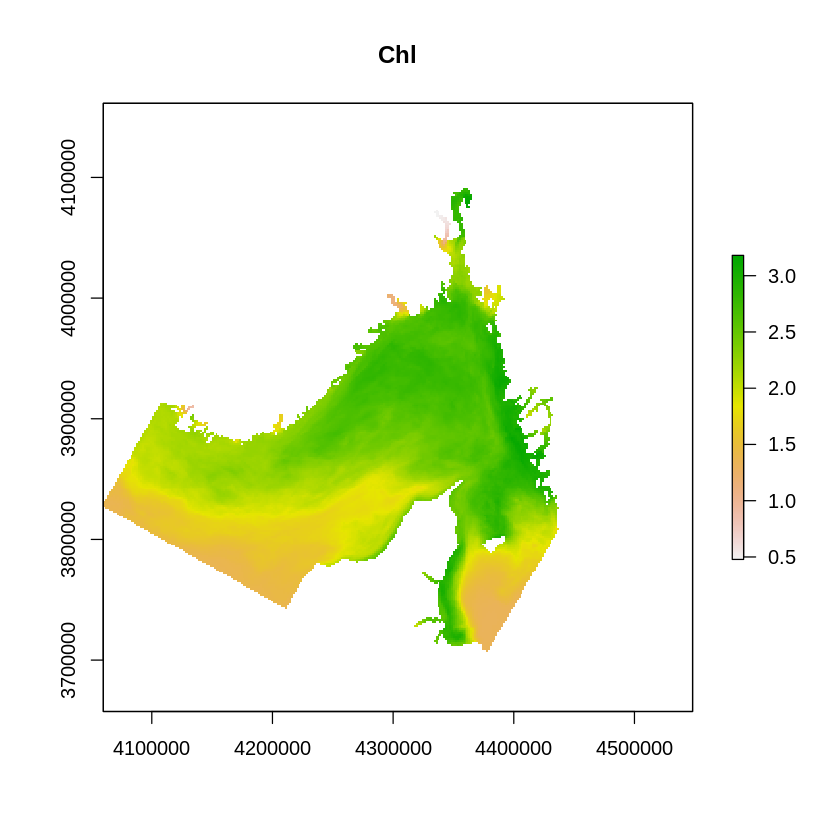

In [6]:
# load the 'blank' raster file
r <- raster("blank_raster.tif")
crs(r)<-CRS("+init=epsg:3035")

# rasterize the MARTINI data to raster r
x <- rasterize(df[, 1:2], r, df[,4], fun=mean)

# plot the raster
plot(x, main=param)

In [7]:
# save the raster file
rasterfile="~/shared/martini/Chl_surf.grd"
rf <- writeRaster(x, filename=rasterfile,overwrite=TRUE)